# PROJECT PHASE 1
## GROUP 1 (AMAZON FASHION)

In [120]:
import pandas as pd
import json
import matplotlib.pyplot as plt

## Data Exploration

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3176 entries, 0 to 3175
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         3176 non-null   float64
 1   verified        3176 non-null   bool   
 2   reviewTime      3176 non-null   object 
 3   reviewerID      3176 non-null   object 
 4   asin            3176 non-null   object 
 5   style           3107 non-null   object 
 6   reviewerName    3176 non-null   object 
 7   reviewText      3160 non-null   object 
 8   summary         3176 non-null   object 
 9   unixReviewTime  3176 non-null   int64  
 10  vote            297 non-null    object 
 11  image           106 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 276.2+ KB
None
   overall  verified  reviewTime     reviewerID        asin  \
0      5.0      True  09 4, 2015  ALJ66O1Y6SLHA  B000K2PJ4K   
1      5.0      True  09 4, 2015  ALJ66O1Y6SLHA  B000K2PJ4K

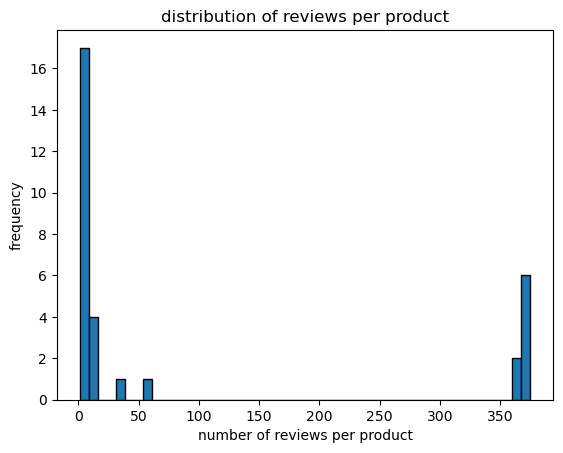

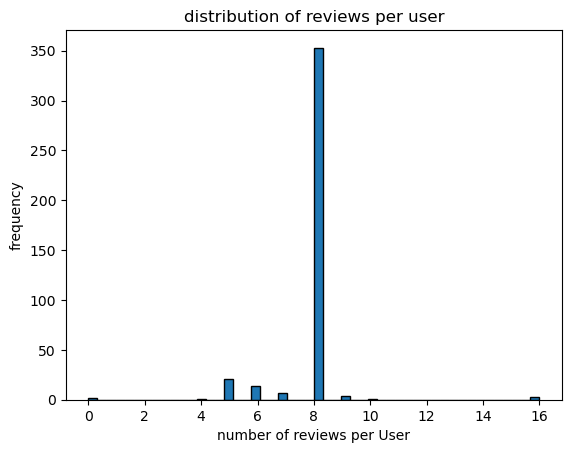

average review length (words): 24.71
max review length: 272
min review length: 0


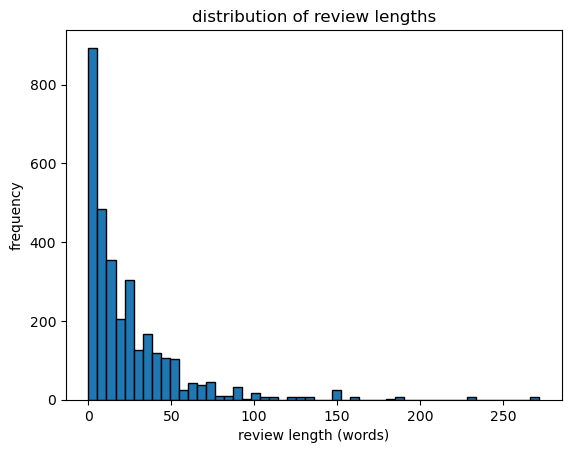

initial dataset size: 3176
number of duplicate reviews: 167
dataset size after removing duplicates: 3087


In [121]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 13 18:21:29 2025

@author: coles
"""

#DELIVERABLE 1)

#creating a function to load line-delimited json
def load_json_lines(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"error decoding json at line {len(data)}: {e}")

    return pd.DataFrame(data)

#loading the dataset (adjust the path based on where you store it locally on your end)
file_path = "AMAZON_FASHION_5.json"
df = load_json_lines(file_path)

#showing some basic dataset info
print(df.info())
print(df.head())

#basic statistics of the dataset (A)
print(f"total reviews: {len(df)}")
print(f"total unique products: {df['asin'].nunique()}")
print(f"total unique users: {df['reviewerID'].nunique()}")
print(f"average rating: {df['overall'].mean():.2f}")
print(df['overall'].value_counts(normalize=True) * 100)

#distribution of reviews per product (B & C)
reviews_per_product = df.groupby("asin")["reviewText"].count()
plt.hist(reviews_per_product, bins=50, edgecolor="black")
plt.xlabel("number of reviews per product")
plt.ylabel("frequency")
plt.title("distribution of reviews per product")
plt.show()

#distribution of reviews per user (D)
reviews_per_user = df.groupby("reviewerID")["reviewText"].count()
plt.hist(reviews_per_user, bins=50, edgecolor="black")
plt.xlabel("number of reviews per User")
plt.ylabel("frequency")
plt.title("distribution of reviews per user")
plt.show()

#review length analysis (E & F)
df["review_length"] = df["reviewText"].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
print(f"average review length (words): {df['review_length'].mean():.2f}")
print(f"max review length: {df['review_length'].max()}")
print(f"min review length: {df['review_length'].min()}")
plt.hist(df["review_length"], bins=50, edgecolor="black")
plt.xlabel("review length (words)")
plt.ylabel("frequency")
plt.title("distribution of review lengths")
plt.show()

#checking for duplicates and dropping duplicates (G) (this could be moved to the front
#of the script so that the duplicates are removed first before other analysis, up
#to you guys)
print(f"initial dataset size: {len(df)}")
duplicates = df[df.duplicated(subset=["reviewText", "reviewerID", "asin"], keep=False)]
print(f"number of duplicate reviews: {len(duplicates)}")
df = df.drop_duplicates(subset=["reviewText", "reviewerID", "asin"], keep='first')
#updated dataset size after removing duplicates
print(f"dataset size after removing duplicates: {len(df)}")


## Text Pre-processing

In [122]:
# Salma

# Step 2a: Labeling the sentiment

def label_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

df["sentiment"] = df["overall"].apply(label_sentiment)

print(df['sentiment'].value_counts())
df.head()

sentiment
Positive    2570
Neutral      322
Negative     195
Name: count, dtype: int64


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,review_length,sentiment
0,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN,4,Positive
5,3.0,True,"05 6, 2015",A3W11493KS6Z2L,B000K2PJ4K,"{'Size:': ' Little Boys', 'Color:': ' White/Bl...",NaeNae,Waaay too small. Will use for futur children!,Oops!,1430870400,NaN,NaN,8,Neutral
6,5.0,True,"05 6, 2015",A3W11493KS6Z2L,B000K2PJ4K,"{'Size:': ' Little Boys', 'Color:': ' Blue/Ora...",NaeNae,Stays vibrant after many washes,Great,1430870400,NaN,NaN,5,Positive
8,5.0,True,"05 6, 2015",A3W11493KS6Z2L,B000K2PJ4K,"{'Size:': ' Little Boys', 'Color:': ' Blue/Pink'}",NaeNae,My son really likes the pink. Ones which I was...,Great,1430870400,NaN,NaN,12,Positive
9,3.0,True,"05 6, 2015",A3W11493KS6Z2L,B000K2PJ4K,"{'Size:': ' Little Boys', 'Color:': ' Light Bl...",NaeNae,Waaay too small. Will use for future child.,Oops!,1430870400,NaN,NaN,8,Neutral


In [ ]:
# Step 2b: Selecting columns for sentiment analysis
selected_columns = ["reviewText", "summary", "sentiment"]
df = df[selected_columns] # can rename to df_selected if needed

# Justification:
# - 'reviewText': Main body of the review, containing the most valuable sentiment information.
# - 'summary': Short version of the review, often useful for reinforcement of sentiment.
# - 'sentiment': The labeled target variable for sentiment analysis. (only needed if labels will be used)
# 'asin' (Product ID) and 'reviewerID' (User ID) could be useful in some cases, to track sentiment trends per product or user. may not be necessary for a basic sentiment analysis.

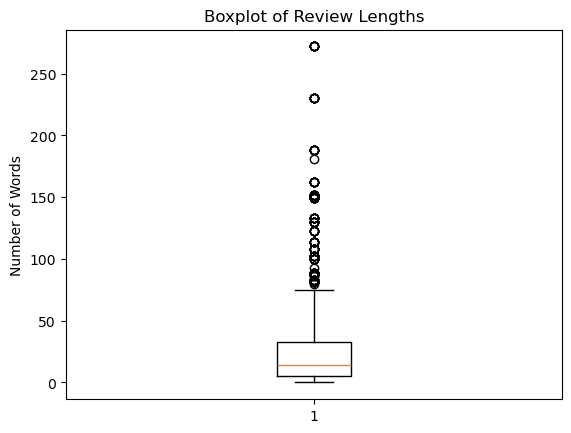

Sample of reviews that are too short (length 0):
    reviewText
172        NaN
285        NaN
535        NaN
648        NaN
890        NaN

Sample of reviews that are too long:
                                            reviewText
13   Pinnacle seems to have more cushioning so my h...
20   Pinnacle seems to have more cushioning so my h...
167  Great shoe. I've had Nike's before and have al...
204  Very good overall.\nNow Ive been a huge Sketch...
208  Glad I read the reviews and ordered a half siz...

Number of reviews that are too short (length 0): 16
Number of reviews that are too long: 163


In [ ]:
# Step 2c: Checking for outliers in review length
review_lengths = df["reviewText"].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

# Boxplot of Review Lengths
plt.boxplot(review_lengths)
plt.title("Boxplot of Review Lengths")
plt.ylabel("Number of Words")
plt.show()

# Identifying extreme outliers
q1 = review_lengths.quantile(0.25)
q3 = review_lengths.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Reviews that are too short (length 0 or below)
too_short = df[review_lengths == 0]

# Reviews that are too long (greater than upper bound)
too_long = df[review_lengths > upper_bound]

# Printing samples of too short and too long reviews
print("Sample of reviews that are too short (length 0):")
print(too_short[["reviewText"]].head())

print("\nSample of reviews that are too long:")
print(too_long[["reviewText"]].head())

# Print number of reviews that are too short and too long
print(f"\nNumber of reviews that are too short (length 0): {len(too_short)}")
print(f"Number of reviews that are too long: {len(too_long)}")

In [ ]:
# Removing both too short and too long reviews (should decide to implement or not)

# df = df[(review_lengths > 0) & (review_lengths <= upper_bound)] # can rename to df_cleaned if needed

# print(f"Number of reviews after removing outliers: {len(df)}")

## Pre-processing

## Model Building